In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special, interpolate, stats
import mpmath
from IPython.display import clear_output
import time

# PHYS 642: Problem Set #3 (streamlined for part 2)

## Part 2. Comptonization of a blackbody spectrum

### e)

In [2]:
#### CONSTANTS ####
h = 4.135667696e-15/1000 # keV*s
c = 299792458*100 # cm/s
m_e = 511/c**2 # 511 kev/c^2

#### PARAMETERS ####
T_s = 0.1 # keV
T_e = 25 # keV
a = np.sqrt(T_e/m_e) # standard deviation for Maxwell-Boltzmann distribution
Emin = 0.005 # keV - for initial blackbody spectrum sampling
Emax = 500 # keV - for initial blackbody spectrum sampling

#### Sampling from a Planck blackbody distribution with inverse transform sampling

In [3]:
def inv_CDF_Planck(E_min, E_max, kT):
    '''
    Description.
    '''
    zeta3 = special.zeta(3)
    CDF = lambda E: 15/np.pi**4 * (np.pi**4/15 + (E/kT)**3*np.log(1-np.exp(-E/kT)) - 3*(E/kT)**2*mpmath.polylog(2, np.exp(-E/kT)) - 6*(E/kT)*mpmath.polylog(3, np.exp(-E/kT)) - 6*mpmath.polylog(4, np.exp(-E/kT)))
#     CDF = lambda E: ((E/kT)**2*np.log(1-np.exp(-E/kT)) - 2*(E/kT)*mpmath.polylog(2, np.exp(-E/kT)) - 2*mpmath.polylog(3, np.exp(-E/kT)) - 2*zeta3)/(2*zeta3)
    
    xs = np.logspace(np.log10(E_min)-1,np.log10(E_max)+1,10000)
    CDF_xs = np.asarray([CDF(xi) for xi in xs])
    inv_CDF_interpolated = interpolate.interp1d(CDF_xs, xs)
    return inv_CDF_interpolated, CDF_xs

In [4]:
def inverse_transform_sampling(inv_CDF_interp, CDF_pts, N):
    '''
    Description.
    '''
    u = np.random.uniform(np.min(CDF_pts), np.max(CDF_pts), N)
    sampled_values = inv_CDF_interp(u).astype('float')
    return sampled_values

In [5]:
# Prepare the inverse CDF function for later use because it takes a while...
inv_CDF_Planck, CDF_pts_Planck = inv_CDF_Planck(Emin, Emax, T_s)

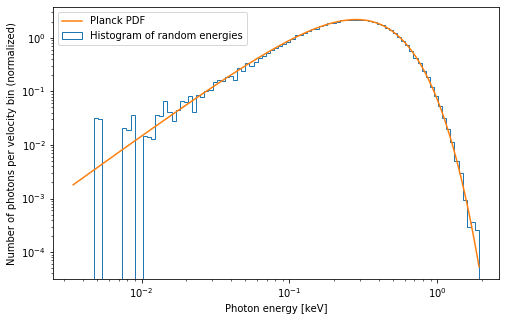

In [6]:
E_photons = inverse_transform_sampling(inv_CDF_Planck, CDF_pts_Planck, 100000)

Es_log = np.logspace(np.log10(E_photons.min()),np.log10(E_photons.max()),200)
PDF_Planck = lambda E, kT: 15*E**3/(np.pi**4*(kT)**4*(np.exp(E/kT)-1))
# nE_Planck = lambda E, kT: E**2/(2*special.zeta(3)*kT**3*(np.exp(E/kT)-1))

plt.figure(figsize=(8,5))
plt.hist(E_photons, density=True, bins=np.logspace(np.log10(E_photons.min()),np.log10(E_photons.max()),100), histtype='step', label='Histogram of random energies')
plt.plot(Es_log, PDF_Planck(Es_log, T_s), label='Planck PDF')
# plt.plot(Es_log, nE_Planck(Es_log, T_s))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Photon energy [keV]')
plt.ylabel('Number of photons per velocity bin (normalized)')
plt.legend()
plt.show()

#### Sampling from a Maxwell-Boltzmann energy distribution

In [7]:
def random_velocity_MB(a, N):
    '''
    Description.
    '''
    vx = np.random.normal(0, a, N)
    vy = np.random.normal(0, a, N)
    vz = np.random.normal(0, a, N)
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    # Make sure there aren't any velocities larger than the speed of light. If there are, replace them with new velocities.
    idx = v >= c
    new_N = np.sum(idx)
    while new_N > 0: 
        new_vx = np.random.normal(0, a, new_N)
        new_vy = np.random.normal(0, a, new_N)
        new_vz = np.random.normal(0, a, new_N)
        new_vs = np.sqrt(new_vx**2 + new_vy**2 + new_vz**2)
        v[idx] = new_vs
        idx = v >= c
        new_N = np.sum(idx)
    return v

0.9973211287115537


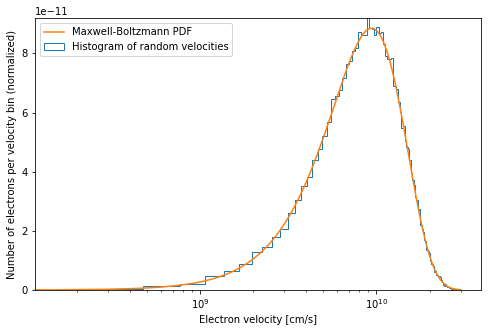

In [8]:
vs = random_velocity_MB(a, 100000)
print(vs.max()/c)

v = np.linspace(0,3e10,200)

plt.figure(figsize=(8,5))
plt.hist(vs, density=True, bins=100, histtype='step', label='Histogram of random velocities')
plt.plot(v, np.sqrt(2/np.pi)*v**2*np.exp(-v**2/(2*a**2))/a**3, label='Maxwell-Boltzmann PDF')
plt.xscale('log')
plt.xlabel('Electron velocity [cm/s]')
plt.ylabel('Number of electrons per velocity bin (normalized)')
plt.legend()
plt.show()

#### Comptonize!

Need the incoming photon direction $\mu = \cos\theta_i$ relative to the direction of electron motion in the lab frame. It is proportional to $1-\beta\mu$.

In [9]:
def get_mu_labframe(beta, N):
    # y comes from a uniform distribution between 0.5*(1-beta)^2/beta and 0.5*(1+beta)^2/beta
    y = np.random.uniform(0.5*(1-beta)**2/beta, 0.5*(1+beta)**2/beta, N)
    # Calculate the corresponding mu value
    mu = (1-np.sqrt(2*beta*y))/beta
    return mu

Randomly sample the scattering angle $\alpha$ of the photon. It is proporitonal to $1+\cos^2\alpha$. Sample using the rejection method.

In [10]:
def get_cos_alpha(N):
    x = np.random.uniform(0,2,N)
    z = np.random.uniform(-1,1,N)
    idx = x >= 1 + z**2
    new_N = np.sum(idx)
    while new_N > 0:
        new_x = np.random.uniform(0,2,new_N)
        new_z = np.random.uniform(-1,1,new_N)
        x[idx] = new_x
        z[idx] = new_z
        idx = x >= 1 + z**2
        new_N = np.sum(idx)
    return z

In [11]:
#### WARNING: TAKES A WHILE
N_photons = 1000000
E_photon_i = inverse_transform_sampling(inv_CDF_Planck, CDF_pts_Planck, N_photons)

In [12]:
def Comptonize(tau, Ei):
    N = len(Ei) # number of photons
    N_scatterings = tau**2
    for i in range(N_scatterings):
        clear_output(wait=True)
        v_electron = random_velocity_MB(a, N)
        beta = v_electron/c
        lorentz = 1/np.sqrt(1-beta**2)
        
        mu = get_mu_labframe(beta, N) # sample N random photon directions
        Ei_rest = Ei*lorentz*(1-beta*mu) # transform photon energies to the electron rest frame
        
        cos_thetai_rest = (mu+beta)/(1+beta*mu) # transform photon directions to the electron rest frame
        thetai_rest = np.arccos(cos_thetai_rest)
        cos_alpha = get_cos_alpha(N) # sample N random scattering directions
        alpha = np.arccos(cos_alpha)    
        phi = np.random.uniform(0,2*np.pi,N) # sample N random angles phi around the beam's cone
        mu_rest = cos_alpha*cos_thetai_rest - np.sin(thetai_rest)*np.sin(alpha)*np.cos(phi) # calculate mu=cos(thetaf) in the electron rest frame
        
        Ef_rest = Ei_rest/(1+Ei_rest/511*(1-cos_alpha)) # Compton scatter the photon energies
        Ef = Ef_rest*lorentz*(1+beta*mu_rest)
        Ei = Ef
        print('Progress:', np.round((i+1)/(N_scatterings)*100, 2), '%')
    return Ef

In [13]:
E_tau1 = Comptonize(1, E_photon_i)
E_tau3 = Comptonize(3, E_photon_i)
E_tau5 = Comptonize(5, E_photon_i)
E_tau7 = Comptonize(7, E_photon_i)
E_tau10 = Comptonize(10, E_photon_i)

Progress: 100.0 %


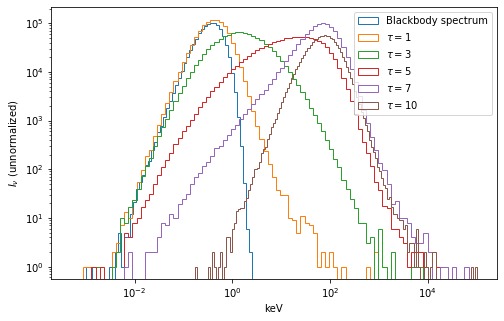

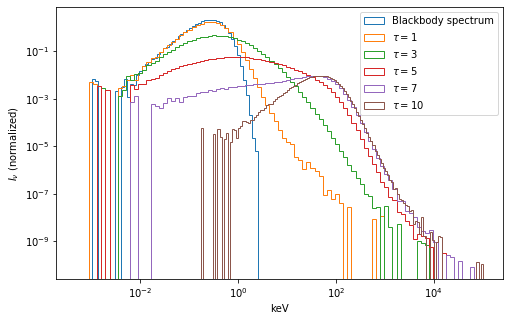

In [15]:
plt.figure(figsize=(8,5))
hist1 = plt.hist(E_photon_i, bins=np.logspace(np.log10(0.0005),np.log10(500),100), histtype='step', label='Blackbody spectrum')
hist2 = plt.hist(E_tau1, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=1$')
hist3 = plt.hist(E_tau3, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=3$')
hist4 = plt.hist(E_tau5, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=5$')
hist5 = plt.hist(E_tau7, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=7$')
hist6 = plt.hist(E_tau10, bins=np.logspace(np.log10(0.0005),np.log10(1e5),200), histtype='step', label=r'$\tau=10$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('keV')
plt.ylabel(r'$I_\nu$ (unnormalized)')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
hist1 = plt.hist(E_photon_i, bins=np.logspace(np.log10(0.0005),np.log10(500),100), histtype='step', label='Blackbody spectrum', density=True)
hist2 = plt.hist(E_tau1, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=1$', density=True)
hist3 = plt.hist(E_tau3, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=3$', density=True)
hist4 = plt.hist(E_tau5, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=5$', density=True)
hist5 = plt.hist(E_tau7, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=7$', density=True)
hist6 = plt.hist(E_tau10, bins=np.logspace(np.log10(0.0005),np.log10(1e5),200), histtype='step', label=r'$\tau=10$', density=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('keV')
plt.ylabel(r'$I_\nu$ (normalized)')
plt.legend()
plt.show()